# Applied exercises

### Exercise 7

In the chapter, we mentioned the use of correlation-based distance and Euclidean distance as dissimilarity measures for hierarchical clustering. It turns out that these two measures are almost equivalent: if each observation has been centered to have mean zero and standard deviation one, and if we let rij denote the correlation between the ith and jth observations, then the quantity 1−rij is proportional to the squared Euclidean distance between the ith and jth observations. On the USArrests data, show that this proportionality holds. Hint: The Euclidean distance can be calculated using the dist() function, and correlations can be calculated using the cor() function.

#### Answer

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler

Let's load the data, convert it to numpy array, and standarize it:

In [4]:
# Load USA arrests data
usarrest_df = pd.read_csv('../data/usa_arrest.csv')

# Convert it to numpy array
features = ['Murder', 'Assault', 'UrbanPop', 'Rape']
usarrest = data_usarrests.loc[:, features].values

# Standarize data
scaler = StandardScaler()
usarrest_scaled = StandardScaler().fit_transform(usarrest)

Let's make sure we have transformed the data to have mean zero and std 1:

In [5]:
# Take mean and std of each column (feature)
mean = np.mean(X,axis=0)
print("These are the columns means: \n" + str(mean))
std = np.std(X, axis=0)
print("\nThese are the columns std: \n" + str(std))

These are the columns means: 
[-7.10542736e-17  1.38777878e-16 -4.39648318e-16  8.59312621e-16]

These are the columns std: 
[1. 1. 1. 1.]


Now we calculate the squared Euclidean distance and the 1- corrlation values for the paiwise comparisons of each row in X:

In [14]:
# Calculate pairwise squared Euclidean and Correlation distance
euclidean = pdist(X, metric='seuclidean')  # array of shape (1225,)
correlation = 1 - pdist(X, metric='correlation')  # array of shape (1225,)

Assuming clustering and squared euclidean are proportional, that would mean: 

$seuclidean = k * correlation$

Then, to calculate if both measures are proportional we could start by computing the median of the constant between them. Later, we can measure the difference between the correlation values and the squared euclidean values multiplied by the constant. If correlation and eucledian are proprotional, this difference should be close to zero: 

In [13]:
# Define constant
constant = correlation/euclidean
median_constant = np.median(constant)

# Compute difference between correlation values and eucledian values multiplied by the constant
difference = correlation - median_constant*euclidean
difference_median = np.median(difference)
print('The median of the difference is: ' + str(difference_median))

The median of the difference is: 0.0


### Exercise 8

In Section 10.2.3, a formula for calculating PVE was given in Equation 10.8. We also saw that the PVE can be obtained using the sdev output of the prcomp() function.

![image_PVE.png](../images/PVE.png)

On the USArrests data, calculate PVE in two ways:
- (a) Using the sdev output of the prcomp() function, as was done in Section 10.2.3.
- (b) By applying Equation 10.8 directly. That is, use the prcomp() function to compute the principal component loadings. Then, use those loadings in Equation 10.8 to obtain the PVE.

These two approaches should give the same results.

Hint: You will only obtain the same results in (a) and (b) if the same data is used in both cases. For instance, if in (a) you performed prcomp() using centered and scaled variables, then you must center and scale the variables before applying Equation 10.3 in (b).

#### Answer

(a) Let's compute PCA over scaled data, using the scikit-learn function:

In [38]:
from sklearn.decomposition import PCA

In [39]:
# Compute PCA
pca = PCA()
usarrest_pca = pca.fit_transform(X)

Let's compute the PVE of each component using the output explained_variance_ratio_ of scikit learn:

In [40]:
# Defined explained variance by each component
variance_ratio = pca.explained_variance_ratio_

# Print PVE in df format
columns_pca = ['PCA_' + str(pca +1) for pca in range(0, np.shape(pca.components_)[1])]
variance_df = pd.DataFrame([variance_ratio], 
                           index=['PVE'], 
                           columns=columns_pca)
print(variance_df)

       PCA_1     PCA_2     PCA_3     PCA_4
PVE  0.62006  0.247441  0.089141  0.043358


(b) Let's compute the PVE using Equation 10.8. 

In [41]:
# Define PCA loadings
pca_loadings = (pca.components_).T
pca_loadings_df = pd.DataFrame(pca_loadings, index=features, columns=columns_pca)

In [42]:
# Compute denominator (this is going to be the same for every PCA component)
matrix_sqr = X**2  # array of shape (50,4)
sum_denominator = np.sum(matrix_sqr)  # float

# Compute numerator for each PCA component
for pca in range(0,len(columns_pca)):
    
    # import corresponding loadings
    loadings = pca_loadings[:,pca] # array of shape (4,)

    # make sure to grab correct loadings (their sum of squares should approximate 1)
    assert np.sum(loadings**2) > 0.99
    
    # compute numerator
    matrix = X * loadings  # array of shape (50,4)
    sum_pred_n = np.sum(matrix, axis=1)  # array of shape (50,)
    sum_pred_n_sqr = sum_pred_n ** 2  # array of shape (50,)
    sum_numerator = np.sum(sum_pred_n_sqr)  # float
    
    # do the calculation
    answer = sum_numerator/sum_denominator
    print('PCA_' + str(pca) + ' PVE :' + str(answer))

PCA_0 PVE :0.6200603947873735
PCA_1 PVE :0.2474412881349605
PCA_2 PVE :0.08914079514520756
PCA_3 PVE :0.043357521932458856


There is a easier way to do this if we take the squared score vectors of each component as the numerator:   

In [43]:
# Compute PVE based on score vectors
for pca in range(0,len(columns_pca)):
    
    # sum squared score vectors of each PCA component
    sum_numerator = np.sum(usarrest_pca[:,pca]**2)  # float
    
    # do the calculation
    answer = sum_numerator/sum_denominator
    print('PCA_' + str(pca) + ' PVE :' + str(answer))  # float

PCA_0 PVE :0.6200603947873742
PCA_1 PVE :0.24744128813496066
PCA_2 PVE :0.0891407951452075
PCA_3 PVE :0.04335752193245883


### Exercise 9

Consider the USArrests data. We will now perform hierarchical clustering on the states.

- (a) Using hierarchical clustering with complete linkage and Euclidean distance, cluster the states.
- (b) Cut the dendrogram at a height that results in three distinct clusters. Which states belong to which clusters?
- (c) Hierarchically cluster the states using complete linkage and Euclidean distance, after scaling the variables to have standard deviation one.
- (d) What effect does scaling the variables have on the hierarchical clustering obtained? In your opinion, should the variables be scaled before the inter-observation dissimilarities are computed? Provide a justification for your answer.

#### Answer:

(a) Let's do hierarchical clutering with complete linkage and Euclidean distance using Scipy:

In [48]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import cut_tree, dendrogram, linkage

%matplotlib inline

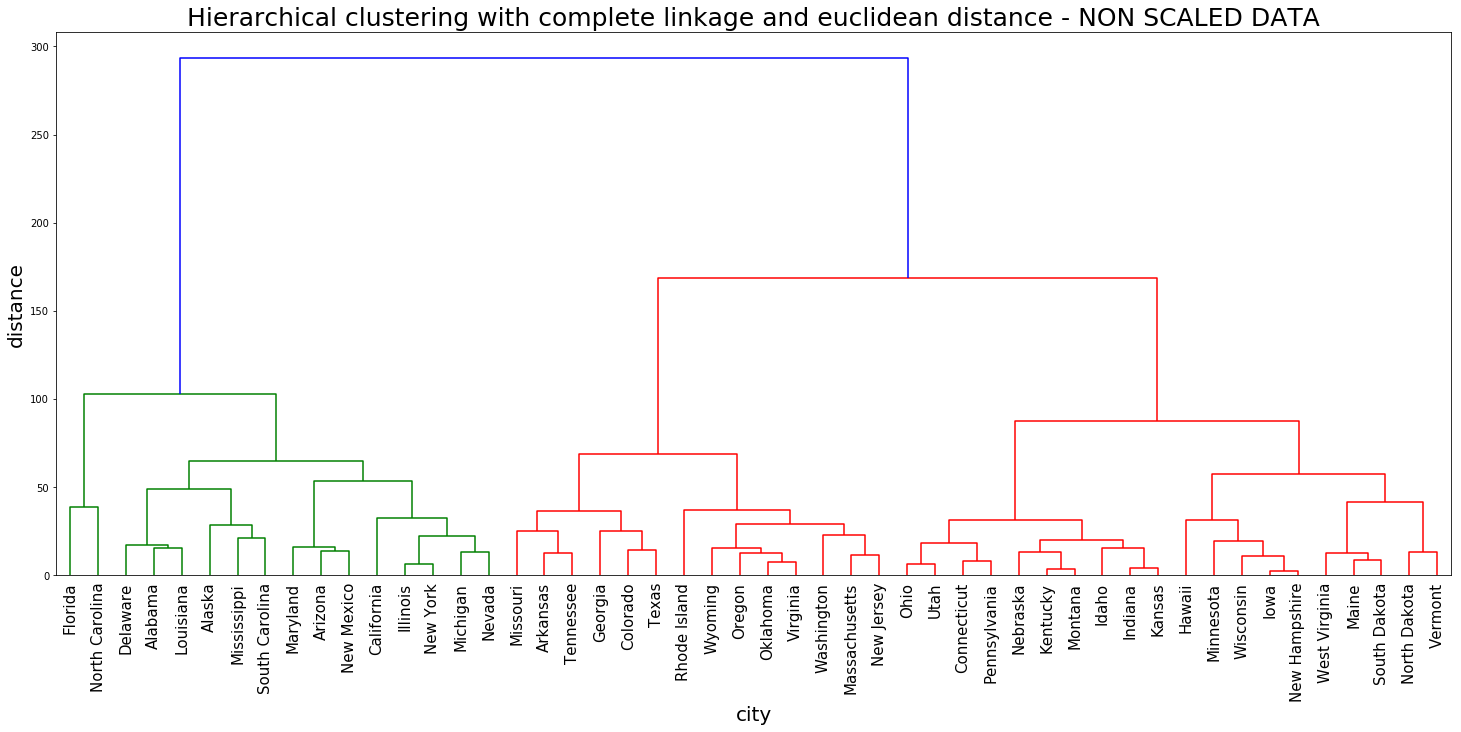

In [54]:
# Perform hierarchical clustering
hc_usarrests = linkage(usarrest, 
                       method='complete', 
                       metric='euclidean')

# Plot dedrogram
states = data_usarrests.index.get_values()  # define labels
plt.figure(figsize=(25, 10))
plt.title('Hierarchical clustering with complete linkage and euclidean distance - NON SCALED DATA', size=25)
plt.xlabel('city', size=20)
plt.ylabel('distance', size=20)
dendrogram(hc_usarrests,
           leaf_rotation=90., 
           leaf_font_size=15, 
           labels=states)
plt.show()

(b) Let's cut the three to three clusters, and print to what cluster each state belongs to:

In [55]:
# Cut tree with three clusters
clusters_3 = cut_tree(hc_usarrests, n_clusters=3)

# Display which states belong to which clusters
clusters_3_df = pd.DataFrame(clusters_3, 
                             index=states, 
                             columns=['Cluster'])
print(clusters_3_df)

                Cluster
Alabama               0
Alaska                0
Arizona               0
Arkansas              1
California            0
Colorado              1
Connecticut           2
Delaware              0
Florida               0
Georgia               1
Hawaii                2
Idaho                 2
Illinois              0
Indiana               2
Iowa                  2
Kansas                2
Kentucky              2
Louisiana             0
Maine                 2
Maryland              0
Massachusetts         1
Michigan              0
Minnesota             2
Mississippi           0
Missouri              1
Montana               2
Nebraska              2
Nevada                0
New Hampshire         2
New Jersey            1
New Mexico            0
New York              0
North Carolina        0
North Dakota          2
Ohio                  2
Oklahoma              1
Oregon                1
Pennsylvania          2
Rhode Island          1
South Carolina        0
South Dakota    

(c) Let's repeat these steps using scaled data:

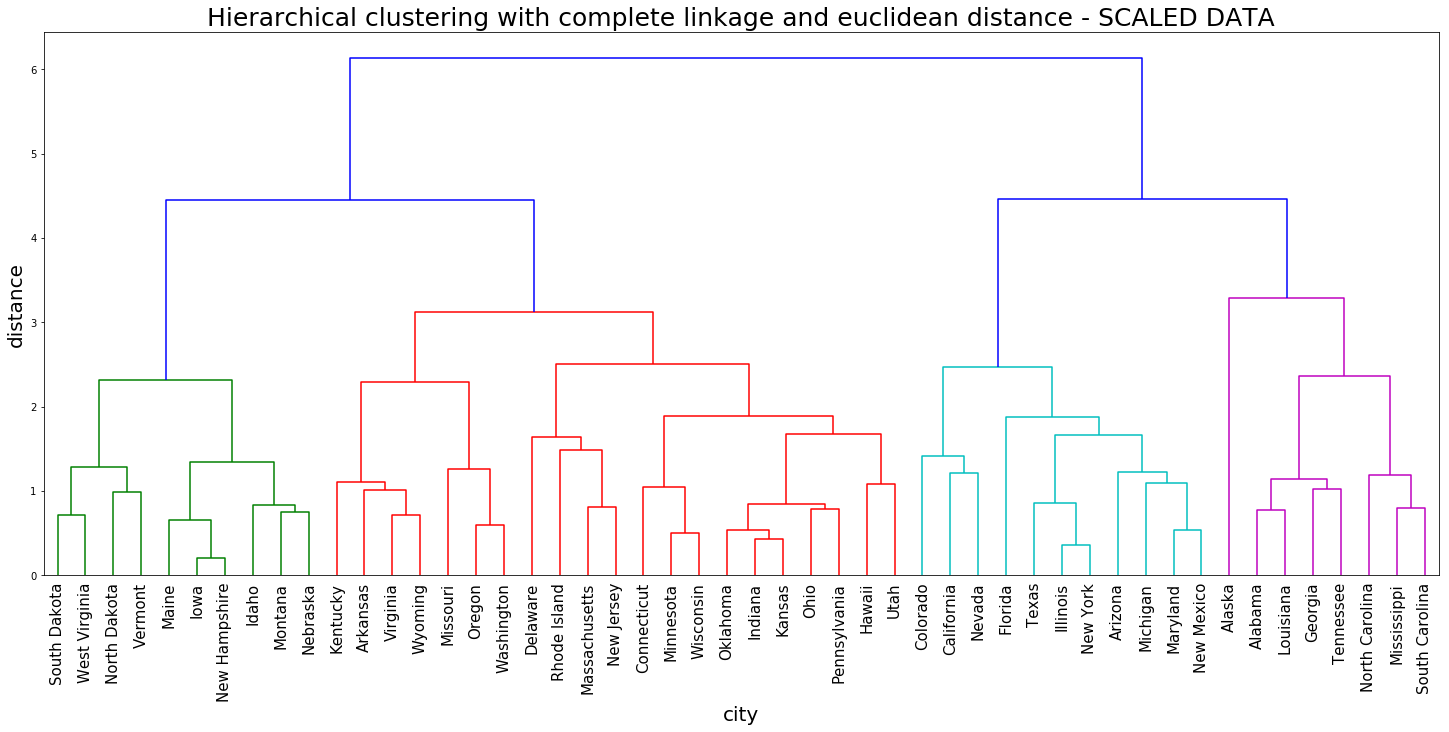

In [56]:
# Perform hierarchical clustering on scaled data
hc_usarrests_scaled = linkage(usarrest_scaled, 
                              method='complete', 
                              metric='euclidean')

# Plot dedrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical clustering with complete linkage and euclidean distance - SCALED DATA', size=25)
plt.xlabel('city', size=20)
plt.ylabel('distance', size=20)
dendrogram(hc_usarrests_scaled,
           leaf_rotation=90., 
           leaf_font_size=15, 
           labels=states)
plt.show()

# Cut tree with three clusters
clusters_3_scaled = cut_tree(hc_usarrests_scaled, n_clusters=3)

In [58]:
# Display which states belong to which clusters, comparing scaled and non-scaled data
clusters = np.append(clusters_3, clusters_3_scaled, axis=1)

clusters_df = pd.DataFrame(clusters,
                             index = states,
                             columns = ['Non-scaled cluster', 'Scaled cluster']
                             )

print(clusters_df)

                Non-scaled cluster  Scaled cluster
Alabama                          0               0
Alaska                           0               0
Arizona                          0               1
Arkansas                         1               2
California                       0               1
Colorado                         1               1
Connecticut                      2               2
Delaware                         0               2
Florida                          0               1
Georgia                          1               0
Hawaii                           2               2
Idaho                            2               2
Illinois                         0               1
Indiana                          2               2
Iowa                             2               2
Kansas                           2               2
Kentucky                         2               2
Louisiana                        0               0
Maine                          

- We observe that the non-scaled data has greater dissimilarity values  

- By using the non-scaled data, we are giving more importance to the features with the highest values (mainly assault and urbanpop, see notebook lab1_pca) and less importance to the others

- Since not all features are in the same units (urbanpop different than the rest), it is recommended to scale the data


### Exercise 10

In this problem, you will generate simulated data, and then perform PCA and K-means clustering on the data.

- (a) Generate a simulated data set with 20 observations in each of three classes (i.e. 60 observations total), and 50 variables. Hint: There are a number of functions in R that you can use to generate data. One example is the rnorm() function; runif() is another option. Be sure to add a mean shift to the observations in each class so that there are three distinct classes.

- (b) Perform PCA on the 60 observations and plot the first two principal component score vectors. Use a different color to indicate the observations in each of the three classes. If the three classes appear separated in this plot, then continue on to part (c). If not, then return to part (a) and modify the simulation so that there is greater separation between the three classes. Do not continue to part (c) until the three classes show at least some separation in the first two principal component score vectors.

- (c) Perform K-means clustering of the observations with K = 3. How well do the clusters that you obtained in K-means clustering compare to the true class labels? Hint: You can use the table() function in R to compare the true class labels to the class labels obtained by clustering. Be careful how you interpret the results: K-means clustering will arbitrarily number the clusters, so you cannot simply check whether the true class labels and clustering labels are the same.

- (d) Perform K-means clustering with K = 2. Describe your results.

- (e) Now perform K-means clustering with K = 4, and describe your results.

- (f) Now perform K-means clustering with K = 3 on the first two principal component score vectors, rather than on the raw data. That is, perform K-means clustering on the 60 × 2 matrix of which the first column is the first principal component score vector, and the second column is the second principal component score vector. Comment on the results.

- (g) Using the scale() function, perform K-means clustering with K = 3 on the data after scaling each variable to have standard deviation one. How do these results compare to those obtained in (b)? Explain.

#### Answer

(a) Let's generate the simulated data:

In [103]:
import random

In [104]:
# Set seed to obtain the same results each time
random.seed(2)

# Create matrix of random numbers with nomal distribution
np.random.seed(2)
X_2 = np.random.rand(60,50)  # array of shape (60,50)

# Create first class
X_2[0:20,0] = X_2[0:20,0] + 3
X_2[0:20,1] = X_2[0:20,1] - 4

# Create second class
X_2[20:40,0] = X_2[20:40,0] - 10
X_2[20:40,1] = X_2[20:40,1] - 2

# Create third class
X_2[40:60,0] = X_2[40:60,0] - 7
X_2[40:60,1] = X_2[40:60,1] + 6

(b) Let's perform PCA and plot its score vectors:

In [105]:
import seaborn as sns

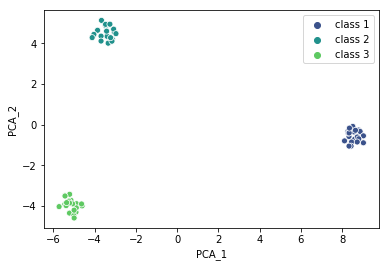

In [106]:
# Compute PCA
pca = PCA()
pca_score_vectors_2 = pca.fit_transform(X_2)

# Transform data into a dataframe
columns_pca_2 = ['PCA_' + str(pca +1) for pca in range(0, np.shape(pca_score_vectors_2)[1])]
pca_score_vectors_df_2 = pd.DataFrame(pca_score_vectors_2, columns=columns_pca_2)

# Define labels for classes
class_1 = ['class 1']* 20
class_2 = ['class 2']* 20
class_3 = ['class 3']* 20
true_labels = class_1 + class_2 + class_3

# Plot
sns.scatterplot(pca_score_vectors_df_2.iloc[:,0], 
                pca_score_vectors_df_2.iloc[:,1], 
                hue=true_labels,
                palette='viridis');

The score vectors separate the data into three clusters, so we can continue with the exercise.

(c) Let's perform K-means clustering of the observations with K = 3 and 20 different intiial configurations.

In [107]:
from sklearn.cluster import KMeans

In [108]:
# Compute k-means
kmeans_3 = KMeans(n_clusters=3, n_init=20)
kmeans_3.fit(X_2)
kmeans_3_labels = (kmeans_3.labels_).tolist()

Let's compare the real class labels with those found by k-means:

In [110]:
# Create data-frame with both labels
labels_true_kmeans = pd.DataFrame({'Real labels': true_labels, 
                                   'K-means labels': kmeans_3_labels})
print(labels_true_kmeans)

   Real labels  K-means labels
0      class 1               1
1      class 1               1
2      class 1               1
3      class 1               1
4      class 1               1
5      class 1               1
6      class 1               1
7      class 1               1
8      class 1               1
9      class 1               1
10     class 1               1
11     class 1               1
12     class 1               1
13     class 1               1
14     class 1               1
15     class 1               1
16     class 1               1
17     class 1               1
18     class 1               1
19     class 1               1
20     class 2               2
21     class 2               2
22     class 2               2
23     class 2               2
24     class 2               2
25     class 2               2
26     class 2               2
27     class 2               2
28     class 2               2
29     class 2               2
30     class 2               2
31     c

As shown, K-means found the real clusters in the data

(d) Let's perform K-means clustering with K = 2: 

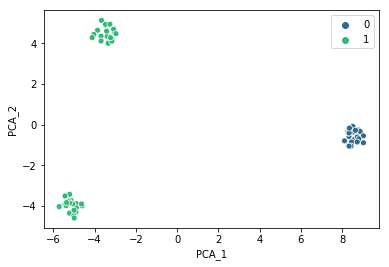

In [112]:
# Compute k-means
kmeans_2 = KMeans(n_clusters=2, n_init=20)
kmeans_2.fit(X_2)
kmeans_2_labels = (kmeans_2.labels_).tolist()

# Plot
sns.scatterplot(pca_score_vectors_df_2.iloc[:,0], pca_score_vectors_df_2.iloc[:,1], 
                hue=kmeans_2_labels,
                palette='viridis');

Setting k = 2 produces a cluster that merges two classes (the most similar of the three)

(e) Let's repeat the process with K = 4:

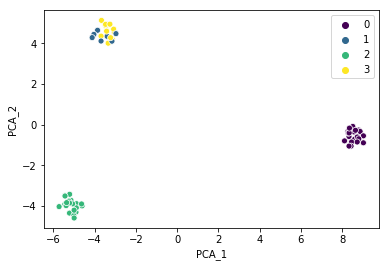

In [114]:
# Compute k-means
kmeans_4 = KMeans(n_clusters=4, n_init=20)
kmeans_4.fit(X_2)
kmeans_4_labels = (kmeans_4.labels_).tolist()

# Plot
sns.scatterplot(pca_score_vectors_df_2.iloc[:,0], pca_score_vectors_df_2.iloc[:,1], 
                hue=kmeans_4_labels,
                palette='viridis');

Setting k=3 produces one of classes to be divided into two clusters

(f) Let's perform K-means clustering with K = 3 on the first two principal component score vectors. So we will perform K-means clustering on the 60 × 2 matrix of which the first column is the first principal component score vector, and the second column is the second principal component score vector. 

Let's start by examining the pca_score vectors:

In [120]:
# Print principal component score vectors
print(pca_score_vectors_df_2.iloc[:,:2].head())

      PCA_1     PCA_2
0  8.806262 -0.264602
1  8.878458 -0.334055
2  9.037772 -0.549288
3  8.523574 -0.087144
4  8.610465 -0.710477


Let's compute k-means and plot the results:

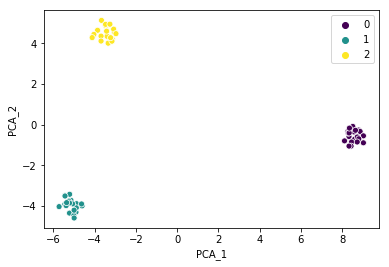

In [121]:
# Compute k-means
kmeans_pca = KMeans(n_clusters=3, n_init=20)
kmeans_pca.fit(pca_score_vectors_2[:,:2])
kmeans_pca_labels = (kmeans_pca.labels_).tolist()

# Plot
sns.scatterplot(pca_score_vectors_df_2.iloc[:,0], pca_score_vectors_df_2.iloc[:,1], 
                hue=kmeans_pca_labels,
                palette='viridis');

K-means can partitionate real classes using pca score vectors

(g) Using the scale() function, perform K-means clustering with K = 3 on the data after scaling each variable to have standard deviation one. How do these results compare to those obtained in (b)? Explain.

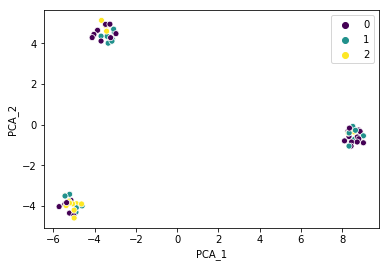

In [123]:
# Standarize data
scaler = StandardScaler()
X_2_scaled = scaler.fit_transform(X_2)

# Compute k-means
kmeans_scaled = KMeans(n_clusters=3, n_init=20)
kmeans_scaled.fit(X_2_scaled)
kmeans_scaled_labels = (kmeans_scaled.labels_).tolist()

# Plot
sns.scatterplot(pca_score_vectors_df_2.iloc[:,0], pca_score_vectors_df_2.iloc[:,1], 
                hue=kmeans_scaled_labels,
                palette='viridis');

K-means does find the real cluster in the data.

- Probably by scaling we are loosing the distance between classes introduced in step (a)

### Exercise 11

On the book website, www.StatLearning.com, there is a gene expression data set (Ch10Ex11.csv) that consists of 40 tissue samples with measurements on 1,000 genes. The first 20 samples are from healthy patients, while the second 20 are from a diseased group.

- (a) Load in the data using read.csv(). You will need to select header=F.
- (b) Apply hierarchical clustering to the samples using correlation based distance, and plot the dendrogram. Do the genes separate the samples into the two groups? Do your results depend on the type of linkage used?
- (c) Your collaborator wants to know which genes differ the most across the two groups. Suggest a way to answer this question, and apply it here.

#### Answer:

(a) Let's start by loading the data:

In [129]:
# Load data
gene_df = pd.read_csv('../data/Ch10Ex11.csv', header=None) # specify that there is no column names
gene_df = gene_df.T # transpose data
print(gene_df.head())

# Get array of values
gene = np.arange(0,1000,1)
gene_array = gene_df.loc[:, gene].values

        0         1         2         3         4         5         6    \
0 -0.961933 -0.292526  0.258788 -1.152132  0.195783  0.030124  0.085418   
1  0.441803 -1.139267 -0.972845 -2.213168  0.593306 -0.691014 -1.113054   
2 -0.975005  0.195837  0.588486 -0.861525  0.282992 -0.403426 -0.677969   
3  1.417504 -1.281121 -0.800258  0.630925  0.247147 -0.729859 -0.562929   
4  0.818815 -0.251439 -1.820398  0.951772  1.978668 -0.364099  0.938194   

        7         8         9    ...       990       991       992       993  \
0  1.116610 -1.218857  1.267369  ...  1.325041 -0.116171 -1.470146 -0.379272   
1  1.341700 -1.277279 -0.918349  ...  0.740838 -0.162392 -0.633375 -0.895521   
2  0.103278 -0.558925 -1.253500  ... -0.435533 -0.235912  1.446660 -1.127459   
3  0.390963 -1.344493 -1.067114  ... -3.065529  1.597294  0.737478 -0.631248   
4 -1.927491  1.159115 -0.240638  ... -2.378938 -0.086946 -0.122342  1.418029   

        994       995       996       997       998       999  
0 -1

(b) Let's apply hierarchical clustering to the samples using correlation based distance with different types of linkage, and plot the dendrogram.

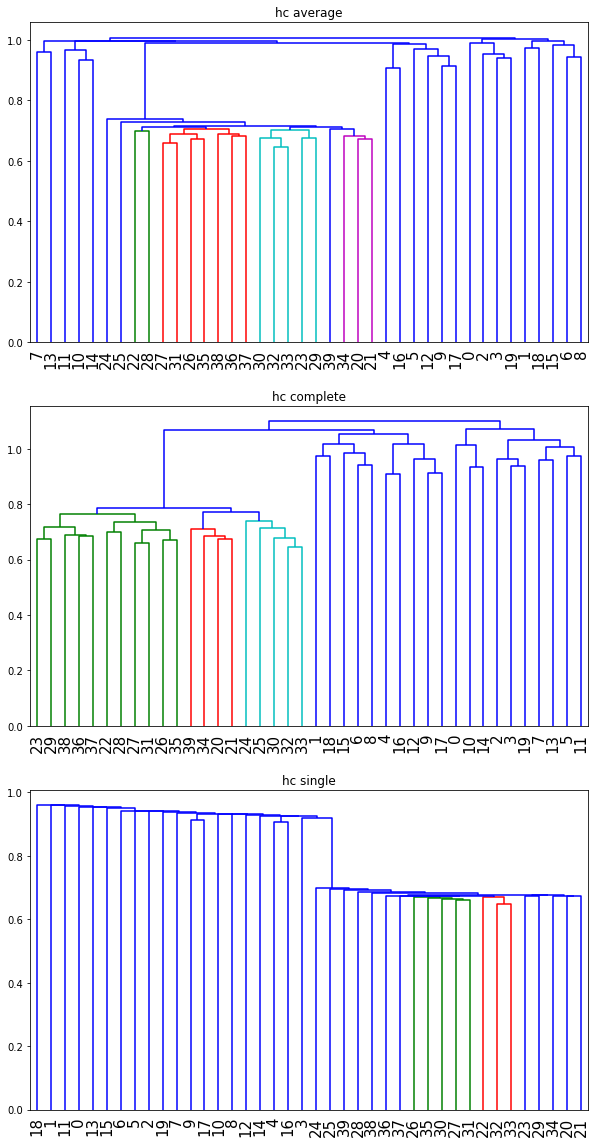

In [130]:
# Perform hierarchical clustering on scaled data
gene_hc_complete = linkage(gene_df, 
                           method='complete', 
                           metric='correlation')
gene_hc_average = linkage(gene_df, 
                          method='average', 
                          metric='correlation')
gene_hc_single = linkage(gene_df, method='single', 
                         metric='correlation')

# Plot dedrograms
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10, 20))

dendrogram(gene_hc_average, 
           ax=ax1, 
           leaf_rotation=90., leaf_font_size=15)
ax1.set_title('hc average');
dendrogram(gene_hc_complete, 
           ax=ax2, 
           leaf_rotation=90., leaf_font_size=15)
ax2.set_title('hc complete');
dendrogram(gene_hc_single, 
           ax=ax3, 
           leaf_rotation=90., leaf_font_size=15)
ax3.set_title('hc single');

In [132]:
# Cut tree with three clusters for each method
cut_genes_complete = cut_tree(gene_hc_complete , n_clusters=2)
cut_genes_average = cut_tree(gene_hc_average , n_clusters=2)
cut_genes_single = cut_tree(gene_hc_single , n_clusters=2)

cut_all = np.hstack([cut_genes_complete, cut_genes_average, cut_genes_single])

# Print results for each method
clusters_genes = pd.DataFrame(cut_all, columns = ['Complete linkage', 'Average linkage', 'Single linkage'])
print(clusters_genes)

    Complete linkage  Average linkage  Single linkage
0                  0                0               0
1                  1                0               0
2                  0                0               0
3                  0                0               0
4                  1                1               0
5                  0                1               0
6                  1                0               0
7                  0                1               0
8                  1                0               0
9                  1                1               0
10                 0                1               0
11                 0                1               0
12                 1                1               0
13                 0                1               0
14                 0                1               0
15                 1                0               0
16                 1                1               0
17                 1        

Genes do not perfectly separate the samples into two groups, although performance improves when using complete and average linkage. 

(c) To know which genes differ the most across the two groups, we can search for the genes with the highest loadings in the first principal components analyses.

Let's start by scaling the data and performing PCA to the genes data:

In [134]:
# Scale data 
scaler = StandardScaler()
gene_scaled = scaler.fit_transform(gene_array)

# Compute PCA
pca_g = PCA()
pca_gene = pca_g.fit_transform(gene_scaled)

Get the sum of the loadings of the first two components:

In [135]:
# Get loadings
pca_loadings_genes = (pca_g.components_ ** 2).T
pca_loadings_genes_two = pca_loadings_genes[:,0:2]
pca_loadings_sum = np.sum(pca_loadings_genes_two, axis=1)

Select genes with the ten highest values of the sum:

In [140]:
# Sort genes
sorted_indices = np.argsort(pca_loadings_sum)

# Select ten genes with ten hightest laodings' values
genes_high = sorted_indices[-10:]

Now let's compute k-means using only the genes selected from before, and print its output:

In [138]:
# Compute k-means and print output
kmeans_gene = KMeans(n_clusters=2, n_init=20)
kmeans_gene.fit(gene_array[:,genes_high])
kmeans_genes_labels = (kmeans_gene.labels_).tolist()
print(kmeans_genes_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


As we can see, clustering data taking only those genes as features makes the classifier perfectly distinguish between healthy and sick adults.

In [139]:
# Compute k-means with random genes and print output
genes_random = np.random.randint(1,1000,10)
kmeans_random_g = KMeans(n_clusters=2, n_init=20)
kmeans_random_g.fit(gene_array[:,genes_random])
kmeans_random_g_labels = (kmeans_random_g.labels_).tolist()
print(kmeans_random_g_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


The separation is not as good (NOTE: to make this step better, we should compare with the results obtained permuting the random genes multiple times).